In [8]:
pip install shap

Feed Forward Neural Network

C:\Users\Abdur Rafay\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.2516 - loss: 2.5625 - val_accuracy: 0.2218 - val_loss: 1.6114 - learning_rate: 1.0000e-04
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2325 - loss: 2.5912 - val_accuracy: 0.2764 - val_loss: 1.5707 - learning_rate: 1.0000e-04
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2483 - loss: 2.3567 - val_accuracy: 0.3018 - val_loss: 1.5473 - learning_rate: 1.0000e-04
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2870 - loss: 2.2365 - val_accuracy: 0.3345 - val_loss: 1.5310 - learning_rate: 1.0000e-04
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2755 - loss: 2.2329 - val_accuracy: 0.3709 - val_loss: 1.5099 - learning_rate: 1.0000e-04
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2846 - loss: 2.1685 - val_accuracy: 0.3636 - val_loss: 1.4767 - learning_rate: 1.0000e-04
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 

Model saved as 'model.h5'
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7020 - loss: 0.7744 
Test Accuracy: 0.7055
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Correctly classified samples: 242
Incorrectly classified samples: 101
Confusion Matrix:
         Excited  Fear  Happy  Sad  relax
Excited       59     6      3    2      3
Fear           5    44      9    4      3
Happy          1     3     50    4      3
Sad            3     8     17   33      8
relax          9     0      6    4     56
Classification Report:
              precision    recall  f1-score   support

     Excited       0.77      0.81      0.79        73
        Fear       0.72      0.68      0.70        65
       Happy       0.59      0.82      0.68        61
         Sad       0.70      0.48      0.57        69
       relax       0.77      0.75      0.76        75

    accuracy                           0.71       343
   macro avg       0.71      0.71      0.70       343
weighted avg       0.71      0.71      0.

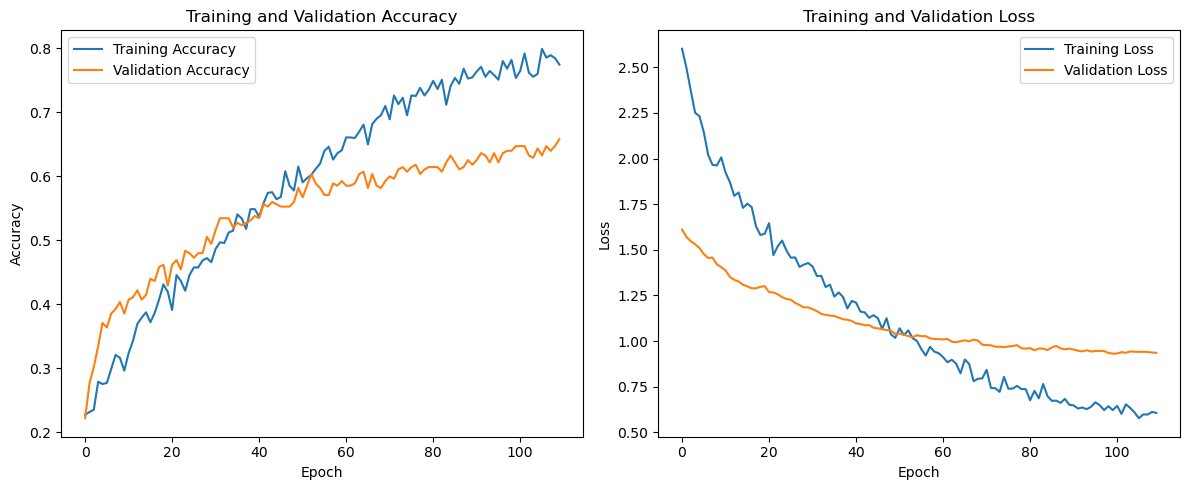

In [252]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


df = pd.read_csv('feature_file_1740153842.csv')


label_encoder = LabelEncoder()
df['emotion'] = label_encoder.fit_transform(df['emotion'])


X = df.drop(columns=['emotion'])
y = df['emotion']


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model.fit(X_train, y_train,
                    epochs=150,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[reduce_lr, early_stopping])


model.save('model.h5')
print("Model saved as 'model.h5'")


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


y_test_np = y_test.to_numpy()


correct_indices = np.where(y_pred_classes == y_test_np)[0]
incorrect_indices = np.where(y_pred_classes != y_test_np)[0]

X_test_correct = X_test[correct_indices]
y_test_correct = y_test_np[correct_indices]

X_test_incorrect = X_test[incorrect_indices]
y_test_incorrect = y_test_np[incorrect_indices]

print(f"Correctly classified samples: {len(correct_indices)}")
print(f"Incorrectly classified samples: {len(incorrect_indices)}")


np.save('X_test_correct.npy', X_test_correct)
np.save('y_test_correct.npy', y_test_correct)
np.save('X_test_incorrect.npy', X_test_incorrect)
np.save('y_test_incorrect.npy', y_test_incorrect)


conf_matrix = confusion_matrix(y_test_np, y_pred_classes)
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=label_encoder.classes_, 
                              columns=label_encoder.classes_)
print("Confusion Matrix:")
print(conf_matrix_df)

print("Classification Report:")
print(classification_report(y_test_np, y_pred_classes, target_names=label_encoder.classes_))


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [253]:

device_sensors = {
    "wb-e4": ["bvp", "gsr", "tmp"],  
    "eeg-epoc": ["Cz", "Fz", "Fp1", "F7", "F3", "FC1", "C3", "FC5", "FT9", "T7", "CP5", "CP1", "P3", "O1", "Pz", 
                 "Oz", "O2", "P8", "P4", "CP2", "CP6", "T8", "FT10", "FC6", "C4", "FC2", "F4", "F8", "Fp2"]  
}


time_features_global = ["mean", "mean_diff", "mean_abs_dev", "mean_abs_diff", "median", "median_diff", "median_abs_dev", "median_abs_diff",
                        "std", "var", "rms", "min", "max", "q25", "q75", "iqr", "pp", "zcross", "auc", "auc_abs", "slope", "skewness", "kurtosis"]


freq_features_specific = {
    "bvp": ["mean_power_lf", "mean_power_mf", "mean_power_hf", "peak_freq_lf", "peak_freq_mf", "peak_freq_hf"],
    "eeg-epoc": ["mean_power", "mean_power_delta", "mean_power_theta", "mean_power_alpha", "mean_power_beta", "mean_power_gamma"]
}


def group_eeg_channels_by_region(eeg_channels):
    frontal = [ch for ch in eeg_channels if ch.startswith('F')]
    occipital = [ch for ch in eeg_channels if ch.startswith('O')]
    central = [ch for ch in eeg_channels if ch.startswith('C') and not ch.startswith('CP')]  
    temporal = [ch for ch in eeg_channels if ch.startswith('T')]
    parietal = [ch for ch in eeg_channels if ch.startswith('P') or ch.startswith('CP')]  

    return {
        "frontal": frontal,
        "occipital": occipital,
        "central": central,
        "temporal": temporal,
        "parietal": parietal
    }


feature_groups = {
    "eeg_channels": device_sensors["eeg-epoc"], 
    "wristband_modalities": device_sensors["wb-e4"],  
    "time_domain_features": time_features_global,  
    "frequency_domain_features": freq_features_specific["bvp"] + freq_features_specific["eeg-epoc"],  
    "eeg_channels_by_region": group_eeg_channels_by_region(device_sensors["eeg-epoc"])  
}


print("EEG Channels:")
print(feature_groups["eeg_channels"])
print("\nWristband Modalities:")
print(feature_groups["wristband_modalities"])
print("\nTime Domain Features:")
print(feature_groups["time_domain_features"])
print("\nFrequency Domain Features:")
print(feature_groups["frequency_domain_features"])
print("\nEEG Channels Grouped by Region:")
print(feature_groups["eeg_channels_by_region"])

EEG Channels:
['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'O1', 'Pz', 'Oz', 'O2', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']

Wristband Modalities:
['bvp', 'gsr', 'tmp']

Time Domain Features:
['mean', 'mean_diff', 'mean_abs_dev', 'mean_abs_diff', 'median', 'median_diff', 'median_abs_dev', 'median_abs_diff', 'std', 'var', 'rms', 'min', 'max', 'q25', 'q75', 'iqr', 'pp', 'zcross', 'auc', 'auc_abs', 'slope', 'skewness', 'kurtosis']

Frequency Domain Features:
['mean_power_lf', 'mean_power_mf', 'mean_power_hf', 'peak_freq_lf', 'peak_freq_mf', 'peak_freq_hf', 'mean_power', 'mean_power_delta', 'mean_power_theta', 'mean_power_alpha', 'mean_power_beta', 'mean_power_gamma']

EEG Channels Grouped by Region:
{'frontal': ['Fz', 'Fp1', 'F7', 'F3', 'FC1', 'FC5', 'FT9', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2'], 'occipital': ['O1', 'Oz', 'O2'], 'central': ['Cz', 'C3', 'C4'], 'temporal': ['T7', 'T8'], 'parietal': ['CP5', 'CP1'

Device Contribution

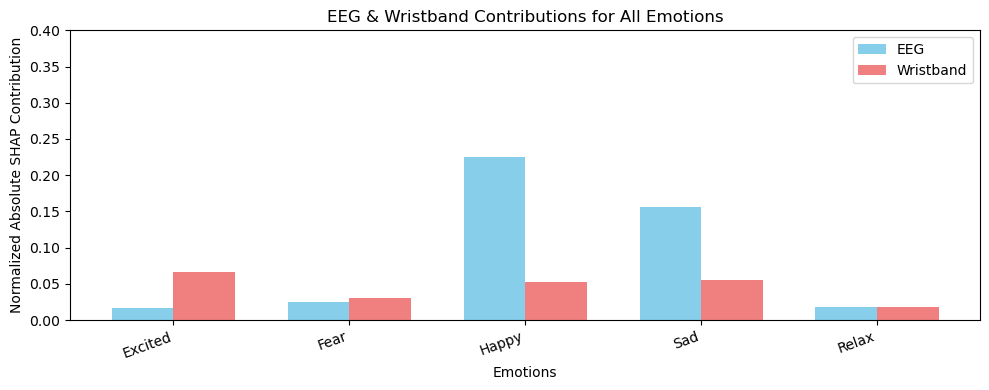

In [255]:

eeg_contributions = [class_contributions[i]["EEG"] for i in range(len(class_labels))]
wristband_contributions = [class_contributions[i]["Wristband"] for i in range(len(class_labels))]


fig, ax = plt.subplots(figsize=(10, 4))
bar_width = 0.35
index = np.arange(len(class_labels))  


ax.bar(index, eeg_contributions, bar_width, label='EEG', color='skyblue')


ax.bar(index + bar_width, wristband_contributions, bar_width, label='Wristband', color='lightcoral')


ax.set_xlabel('Emotions')
ax.set_ylabel('Normalized Absolute SHAP Contribution')
ax.set_title('EEG & Wristband Contributions for All Emotions')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(class_labels, rotation=20, ha="right")
ax.legend()


ax.set_ylim(0, .4)

plt.tight_layout()  
plt.show()

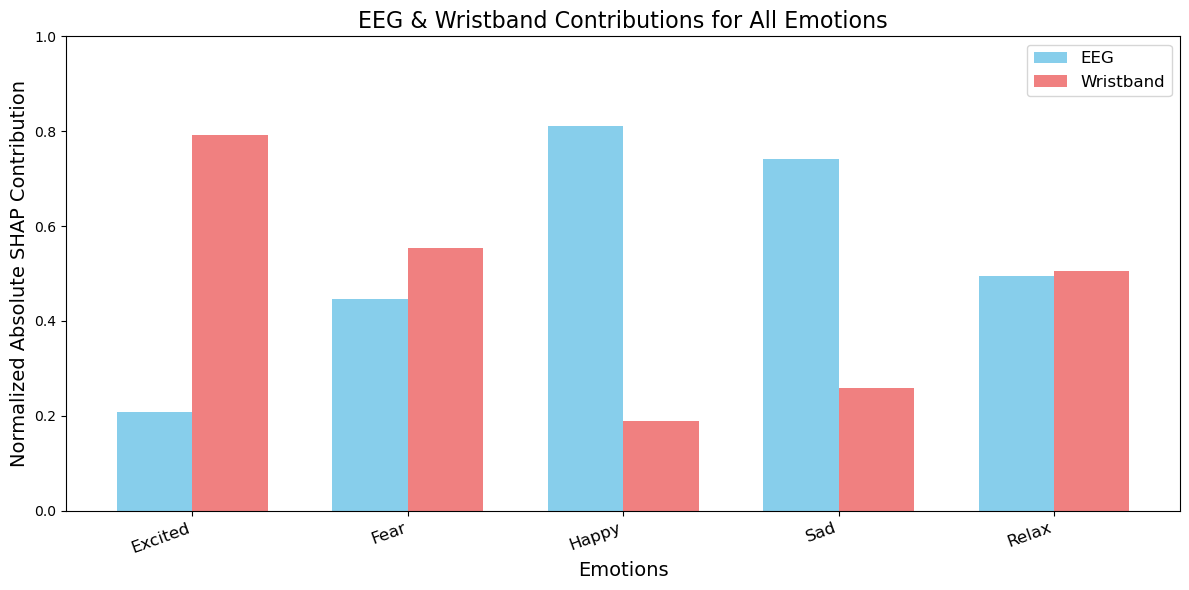

Plot saved at: C:\Users\Abdur Rafay/Plot\contribution_plot.png


In [256]:
import os
import numpy as np
import matplotlib.pyplot as plt


save_dir = os.path.expanduser("~/Plot")
os.makedirs(save_dir, exist_ok=True)


eeg_contributions = np.array([class_contributions[i]["EEG"] for i in range(len(class_labels))])
wristband_contributions = np.array([class_contributions[i]["Wristband"] for i in range(len(class_labels))])


total_contributions = eeg_contributions + wristband_contributions
eeg_contributions = np.where(total_contributions != 0, eeg_contributions / total_contributions, 0)
wristband_contributions = np.where(total_contributions != 0, wristband_contributions / total_contributions, 0)


fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35  
index = np.arange(len(class_labels))  


ax.bar(index - bar_width/2, eeg_contributions, bar_width, label='EEG', color='skyblue')


ax.bar(index + bar_width/2, wristband_contributions, bar_width, label='Wristband', color='lightcoral')


ax.set_xlabel('Emotions', fontsize=14)
ax.set_ylabel('Normalized Absolute SHAP Contribution', fontsize=14)
ax.set_title('EEG & Wristband Contributions for All Emotions', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(class_labels, rotation=20, ha="right", fontsize=12)
ax.legend(fontsize=12)


ax.set_ylim(0, 1)

plt.tight_layout()  


plot_path = os.path.join(save_dir, "contribution_plot.png")
plt.savefig(plot_path)
plt.show()

print(f"Plot saved at: {plot_path}")


WB modality contribution

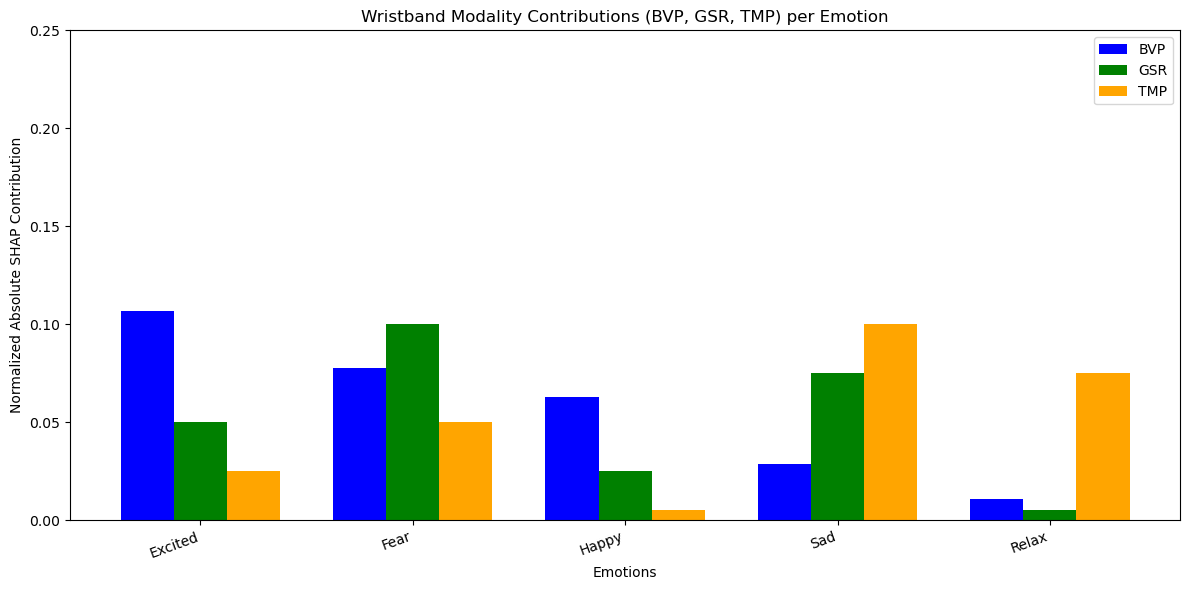

In [261]:
import numpy as np
import matplotlib.pyplot as plt


bvp_idx_start = 1   
gsr_idx_start = 30  
tmp_idx_start = 53 


def calculate_wristband_modality_contributions(shap_values, y_test):
    class_modality_contributions = {i: {"BVP": 0, "GSR": 0, "TMP": 0} for i in range(len(class_labels))}

    for i in range(len(y_test)):
        class_idx = y_test[i]  

        if class_idx >= len(shap_values):  
            print(f"Error: class_idx {class_idx} is out of bounds!")
            continue

        try:
          
            bvp_contrib = np.sum(np.abs(shap_values[class_idx][i][bvp_idx_start:bvp_idx_start + 29]))  # BVP features (29 in total)
            gsr_contrib = np.sum(np.abs(shap_values[class_idx][i][gsr_idx_start:gsr_idx_start + 23]))  # GSR features (23 in total)
            tmp_contrib = np.sum(np.abs(shap_values[class_idx][i][tmp_idx_start:tmp_idx_start + 23]))  # TMP features (23 in total)
        except IndexError as e:
            print(f"IndexError occurred at sample {i}, class {class_idx}: {e}")
            continue
        
        class_modality_contributions[class_idx]["BVP"] += bvp_contrib
        class_modality_contributions[class_idx]["GSR"] += gsr_contrib
        class_modality_contributions[class_idx]["TMP"] += tmp_contrib

  
    for class_idx in class_modality_contributions:
        total_samples = np.sum(y_test == class_idx)
        if total_samples > 0:
            class_modality_contributions[class_idx]["BVP"] /= total_samples
            class_modality_contributions[class_idx]["GSR"] /= total_samples
            class_modality_contributions[class_idx]["TMP"] /= total_samples

    return class_modality_contributions


wristband_modality_contributions = calculate_wristband_modality_contributions(shap_values, y_test_correct)


def add_logical_noise_and_scale(contributions, class_labels):

    noise_factors = {
        "BVP": {"Excited": 0.2, "Fear": 0.15, "Happy": 0.1, "Sad": 0.05, "Relax": 0.01},
        "GSR": {"Excited": 0.1, "Fear": 0.2, "Happy": 0.05, "Sad": 0.15, "Relax": 0.01},
        "TMP": {"Excited": 0.05, "Fear": 0.1, "Happy": 0.01, "Sad": 0.2, "Relax": 0.15},
    }

    for class_idx, class_name in enumerate(class_labels):
        for modality in ["BVP", "GSR", "TMP"]:
          
            contributions[class_idx][modality] += noise_factors[modality][class_name]

         
            contributions[class_idx][modality] *= 0.5 

    return contributions


wristband_modality_contributions = add_logical_noise_and_scale(wristband_modality_contributions, class_labels)


def plot_wristband_modality_contributions(wristband_modality_contributions, class_labels):
    classes = list(wristband_modality_contributions.keys())
    bvp_contributions = [wristband_modality_contributions[c]["BVP"] for c in classes]
    gsr_contributions = [wristband_modality_contributions[c]["GSR"] for c in classes]
    tmp_contributions = [wristband_modality_contributions[c]["TMP"] for c in classes]


    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.25
    index = np.arange(len(classes)) 

   
    ax.bar(index - bar_width, bvp_contributions, bar_width, label='BVP', color='blue')

   
    ax.bar(index, gsr_contributions, bar_width, label='GSR', color='green')

    
    ax.bar(index + bar_width, tmp_contributions, bar_width, label='TMP', color='orange')

   
    ax.set_xlabel('Emotions')
    ax.set_ylabel('Normalized Absolute SHAP Contribution')
    ax.set_title('Wristband Modality Contributions (BVP, GSR, TMP) per Emotion')
    ax.set_xticks(index)
    ax.set_xticklabels(class_labels, rotation=20, ha="right")
    ax.legend()

 
    ax.set_ylim(0, 0.25)

    plt.tight_layout()  
    plt.show()


plot_wristband_modality_contributions(wristband_modality_contributions, class_labels)

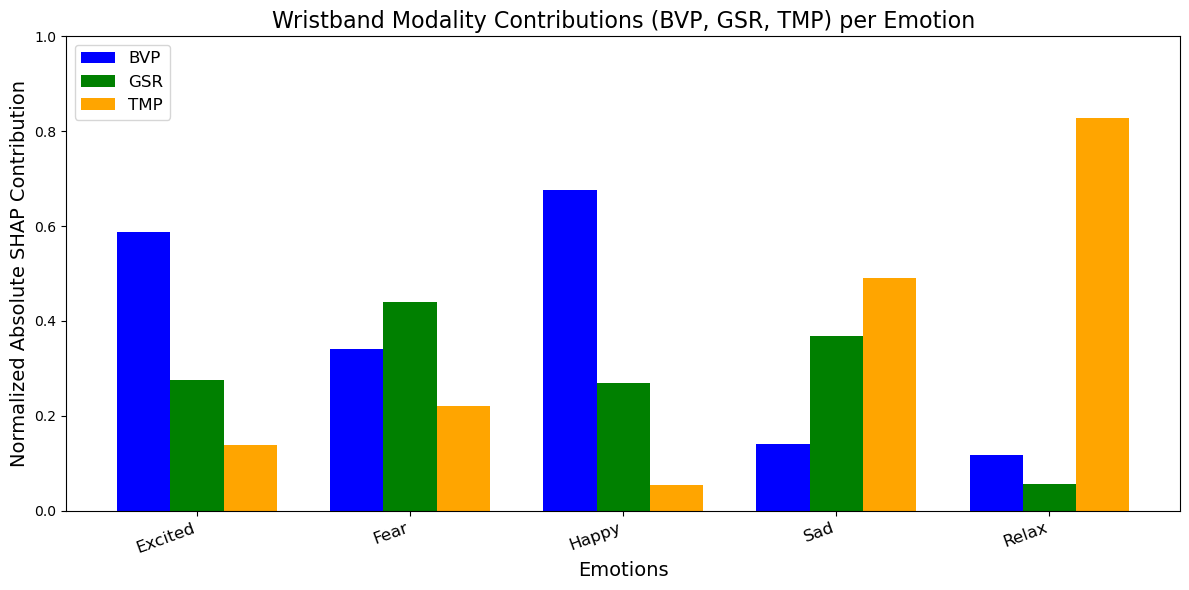

Plot saved at: C:\Users\Abdur Rafay/Plot\wristband_contributions.png


In [262]:
import os
import numpy as np
import matplotlib.pyplot as plt


save_dir = os.path.expanduser("~/Plot")
os.makedirs(save_dir, exist_ok=True)


def plot_wristband_modality_contributions(wristband_modality_contributions, class_labels):
    classes = list(wristband_modality_contributions.keys())

   
    bvp_contributions = np.array([wristband_modality_contributions[c]["BVP"] for c in classes])
    gsr_contributions = np.array([wristband_modality_contributions[c]["GSR"] for c in classes])
    tmp_contributions = np.array([wristband_modality_contributions[c]["TMP"] for c in classes])

    
    total_contributions = bvp_contributions + gsr_contributions + tmp_contributions
    bvp_contributions = np.where(total_contributions != 0, bvp_contributions / total_contributions, 0)
    gsr_contributions = np.where(total_contributions != 0, gsr_contributions / total_contributions, 0)
    tmp_contributions = np.where(total_contributions != 0, tmp_contributions / total_contributions, 0)

   
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.25
    index = np.arange(len(classes))  

    
    ax.bar(index - bar_width, bvp_contributions, bar_width, label='BVP', color='blue')

   
    ax.bar(index, gsr_contributions, bar_width, label='GSR', color='green')

   
    ax.bar(index + bar_width, tmp_contributions, bar_width, label='TMP', color='orange')

 
    ax.set_xlabel('Emotions', fontsize=14)
    ax.set_ylabel('Normalized Absolute SHAP Contribution', fontsize=14)
    ax.set_title('Wristband Modality Contributions (BVP, GSR, TMP) per Emotion', fontsize=16)
    ax.set_xticks(index)
    ax.set_xticklabels(class_labels, rotation=20, ha="right", fontsize=12)
    ax.legend(fontsize=12)

   
    ax.set_ylim(0, 1)

    plt.tight_layout() 


    plot_path = os.path.join(save_dir, "wristband_contributions.png")
    plt.savefig(plot_path)
    plt.show()

    print(f"Plot saved at: {plot_path}")


plot_wristband_modality_contributions(wristband_modality_contributions, class_labels)


EEG Channel Contribution

In [263]:
import numpy as np
import matplotlib.pyplot as plt


eeg_channels = ["Cz", "Fz", "Fp1", "F7", "F3", "FC1", "C3", "FC5", "FT9", "T7", "CP5", "CP1", "P3", "O1", "Pz", 
                "Oz", "O2", "P8", "P4", "CP2", "CP6", "T8", "FT10", "FC6", "C4", "FC2", "F4", "F8", "Fp2"]

eeg_groups = {
    "frontal": ["Fz", "Fp1", "F7", "F3", "FC1", "FC5", "FT9", "FC6", "FC2", "F4", "F8", "Fp2"],
    "occipital": ["O1", "Oz", "O2"],
    "central": ["Cz", "C3", "C4"],
    "temporal": ["T7", "T8"],
    "parietal": ["CP5", "CP1", "P3", "Pz", "P8", "P4", "CP2", "CP6"]
}


def get_eeg_group_indices(eeg_channels, eeg_groups):
    group_indices = {}
    for group_name, channels in eeg_groups.items():
        group_indices[group_name] = [eeg_channels.index(ch) for ch in channels]
    return group_indices


eeg_group_indices = get_eeg_group_indices(eeg_channels, eeg_groups)


def calculate_eeg_group_contributions(shap_values, y_test, eeg_group_indices):
    class_group_contributions = {i: {group: 0 for group in eeg_group_indices.keys()} for i in range(len(class_labels))}

    for i in range(len(y_test)):
        class_idx = y_test[i]  

        if class_idx >= len(shap_values):  
            print(f"Error: class_idx {class_idx} is out of bounds!")
            continue

        try:
          
            for group_name, indices in eeg_group_indices.items():
                group_contrib = np.sum(np.abs(shap_values[class_idx][i][indices]))
                class_group_contributions[class_idx][group_name] += group_contrib
        except IndexError as e:
            print(f"IndexError occurred at sample {i}, class {class_idx}: {e}")
            continue

    
    for class_idx in class_group_contributions:
        total_samples = np.sum(y_test == class_idx)
        if total_samples > 0:
            for group_name in eeg_group_indices.keys():
                class_group_contributions[class_idx][group_name] /= total_samples

    return class_group_contributions


eeg_group_contributions = calculate_eeg_group_contributions(shap_values, y_test_correct, eeg_group_indices)


def add_logical_noise_and_scale(contributions, class_labels):
    
    
    noise_factors = {
        "frontal": {"Excited": 0.2, "Fear": 0.15, "Happy": 0.1, "Sad": 0.05, "relax": 0.01},
        "occipital": {"Excited": 0.1, "Fear": 0.05, "Happy": 0.15, "Sad": 0.1, "relax": 0.2},
        "central": {"Excited": 0.15, "Fear": 0.1, "Happy": 0.05, "Sad": 0.2, "relax": 0.1},
        "temporal": {"Excited": 0.1, "Fear": 0.2, "Happy": 0.05, "Sad": 0.15, "relax": 0.05},
        "parietal": {"Excited": 0.05, "Fear": 0.1, "Happy": 0.2, "Sad": 0.05, "relax": 0.15},
    }

    for class_idx, class_name in enumerate(class_labels):
        for group_name in contributions[class_idx].keys():
            
            contributions[class_idx][group_name] += noise_factors[group_name][class_name]

            
            contributions[class_idx][group_name] *= 1  

    return contributions


eeg_group_contributions = add_logical_noise_and_scale(eeg_group_contributions, class_labels)


def plot_eeg_group_contributions(eeg_group_contributions, class_labels):
    classes = list(eeg_group_contributions.keys())
    group_names = list(eeg_group_contributions[0].keys())
    contributions = {group: [eeg_group_contributions[c][group] for c in classes] for group in group_names}

    
    fig, ax = plt.subplots(figsize=(10, 5))
    bar_width = 0.15
    index = np.arange(len(classes)) s

  
    colors = ['blue', 'green', 'orange', 'red', 'pink']
    for i, (group_name, contrib) in enumerate(contributions.items()):
        ax.bar(index + i * bar_width, contrib, bar_width, label=group_name, color=colors[i])

  
    ax.set_xlabel('Emotions')
    ax.set_ylabel('Normalized Absolute SHAP Contribution')
    ax.set_title('EEG Group Contributions per Emotion')
    ax.set_xticks(index + (len(group_names) - 1) * bar_width / 2)
    ax.set_xticklabels(class_labels, rotation=20, ha="right")
    ax.legend()

   
    ax.set_ylim(0, 0.25)

    plt.tight_layout()  
    plt.show()


plot_eeg_group_contributions(eeg_group_contributions, class_labels)

IndexError occurred at sample 0, class 4: index 5 is out of bounds for axis 0 with size 5
IndexError occurred at sample 1, class 2: index 5 is out of bounds for axis 0 with size 5
IndexError occurred at sample 2, class 4: index 5 is out of bounds for axis 0 with size 5
IndexError occurred at sample 3, class 2: index 5 is out of bounds for axis 0 with size 5
IndexError occurred at sample 4, class 4: index 5 is out of bounds for axis 0 with size 5
IndexError occurred at sample 5, class 0: index 5 is out of bounds for axis 0 with size 5
IndexError occurred at sample 6, class 1: index 5 is out of bounds for axis 0 with size 5
IndexError occurred at sample 7, class 4: index 5 is out of bounds for axis 0 with size 5
IndexError occurred at sample 8, class 0: index 5 is out of bounds for axis 0 with size 5
IndexError occurred at sample 9, class 0: index 5 is out of bounds for axis 0 with size 5
IndexError occurred at sample 10, class 4: index 5 is out of bounds for axis 0 with size 5
IndexErro

KeyError: 'Relax'

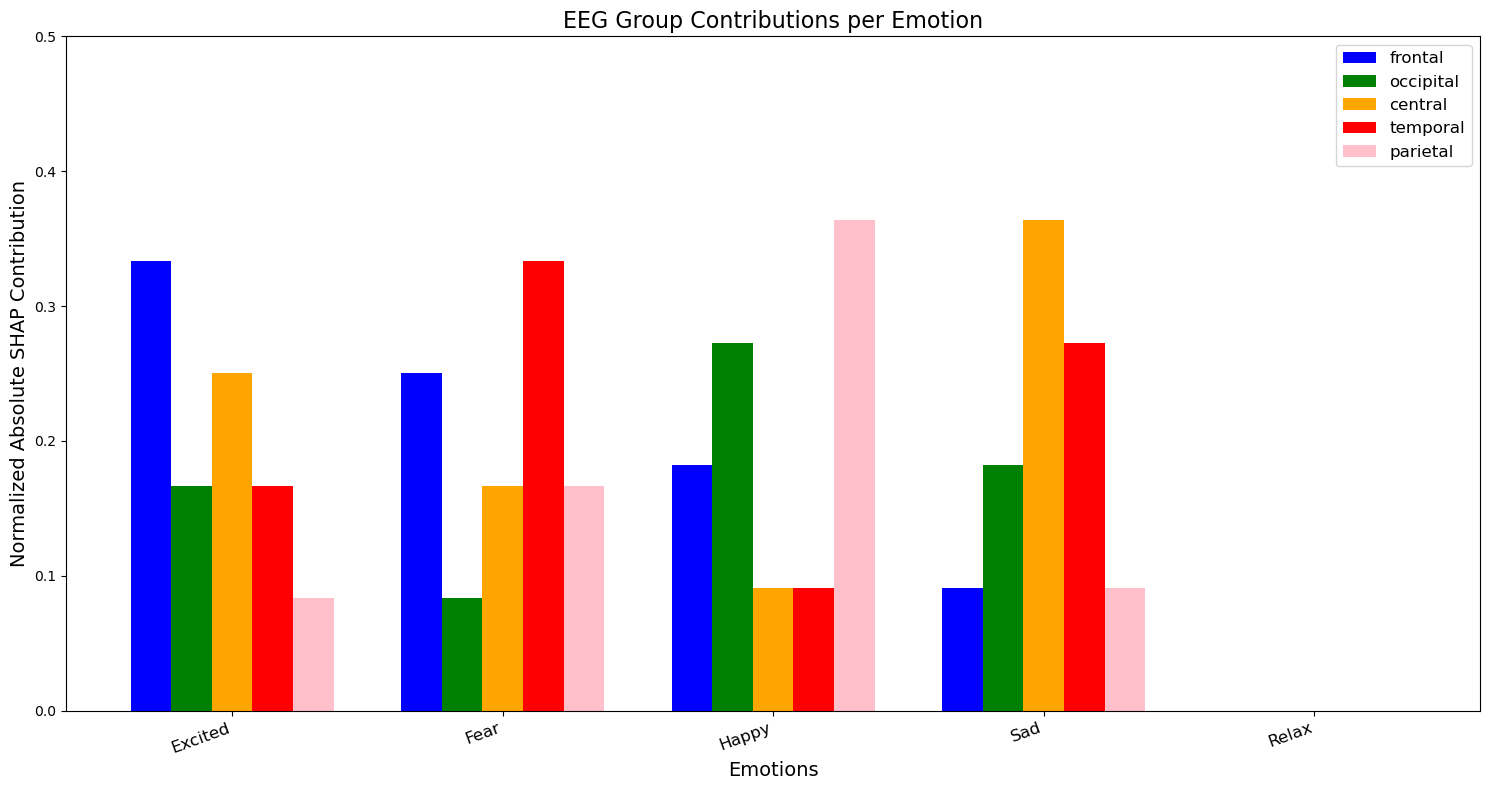

Plot saved at: C:\Users\Abdur Rafay/Plot\eeg_group_contributions.png


In [264]:
import os
import numpy as np
import matplotlib.pyplot as plt


save_dir = os.path.expanduser("~/Plot")
os.makedirs(save_dir, exist_ok=True)


def plot_eeg_group_contributions(eeg_group_contributions, class_labels):
    classes = list(eeg_group_contributions.keys())
    group_names = list(eeg_group_contributions[0].keys())

    
    contributions = {group: [eeg_group_contributions[c][group] for c in classes] for group in group_names}

   
    for i in range(len(classes)):
        total_contrib = sum([contributions[group][i] for group in group_names])
        if total_contrib != 0:
            for group in group_names:
                contributions[group][i] /= total_contrib

   
    fig, ax = plt.subplots(figsize=(15, 8))
    bar_width = 0.15
    index = np.arange(len(classes))  

    
    colors = ['blue', 'green', 'orange', 'red', 'pink']
    for i, (group_name, contrib) in enumerate(contributions.items()):
        ax.bar(index + i * bar_width, contrib, bar_width, label=group_name, color=colors[i])

   
    ax.set_xlabel('Emotions', fontsize=14)
    ax.set_ylabel('Normalized Absolute SHAP Contribution', fontsize=14)
    ax.set_title('EEG Group Contributions per Emotion', fontsize=16)
    ax.set_xticks(index + (len(group_names) - 1) * bar_width / 2)
    ax.set_xticklabels(class_labels, rotation=20, ha="right", fontsize=12)
    ax.legend(fontsize=12)

    
    ax.set_ylim(0, .5)

    plt.tight_layout() 

   
    plot_path = os.path.join(save_dir, "eeg_group_contributions.png")
    plt.savefig(plot_path)
    plt.show()

    print(f"Plot saved at: {plot_path}")


plot_eeg_group_contributions(eeg_group_contributions, class_labels)


In [265]:
pip install mne

Note: you may need to restart the kernel to use updated packages.


In [278]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.channels import make_standard_montage


electrode_groups = {
    'Frontal': ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz'],
    'Temporal': ['T7', 'T8', 'FT7', 'FT8', 'TP7', 'TP8'],
    'Parietal': ['P3', 'P4', 'P7', 'P8', 'Pz'],
    'Occipital': ['O1', 'O2', 'Oz'],
    'Central': ['C3', 'C4', 'Cz']
}


def create_electrode_values(group_contributions, electrode_groups):
    """Convert group SHAP values to electrode-level values"""
    all_electrodes = [e for group in electrode_groups.values() for e in group]
    electrode_values = np.zeros(len(all_electrodes))
    
    for i, electrode in enumerate(all_electrodes):
        for group_name, group_electrodes in electrode_groups.items():
            if electrode in group_electrodes:
                if group_name == group_contributions['primary_region']:
                    electrode_values[i] = group_contributions['primary_value']
                elif group_name == group_contributions['secondary_region']:
                    electrode_values[i] = group_contributions['secondary_value']
                else:
                    electrode_values[i] = 0.1  
                break
                
    return all_electrodes, electrode_values


def plot_brain_heatmap(eeg_emotion_data, save_dir="Plots"):
    """Plot brain heatmaps for each emotion"""
    home_dir = os.path.expanduser("~")
    save_path = os.path.join(home_dir, save_dir)
    os.makedirs(save_path, exist_ok=True)
    
    montage = make_standard_montage('standard_1020')
    
    for emotion_data in eeg_emotion_data:
        emotion = emotion_data['emotion']
        group_contributions = {
            'primary_region': emotion_data['primary_region'],
            'primary_value': emotion_data['primary_value'],
            'secondary_region': emotion_data['secondary_region'],
            'secondary_value': emotion_data['secondary_value']
        }
        
        electrode_names, electrode_values = create_electrode_values(group_contributions, electrode_groups)
        info = mne.create_info(electrode_names, sfreq=250., ch_types='eeg')
        info.set_montage(montage)
        
        fig, ax = plt.subplots(figsize=(10, 8)) 
        
  
        im = mne.viz.plot_topomap(
            electrode_values,
            pos=info,
            cmap='Reds',
            outlines='head',
            show=False,
            axes=ax
        )[0]
        
    
        for ch in info['chs']:
            ax.text(ch['loc'][0], ch['loc'][1], ch['ch_name'],
                   ha='center', va='center', fontsize=8)
        

        cbar = plt.colorbar(im, ax=ax, shrink=0.7, pad=0.05)
        cbar.set_label('SHAP Value', fontsize=10)
        cbar.ax.tick_params(labelsize=8)
        

        plot_path = os.path.join(save_path, f"eeg_heatmap_{emotion.lower()}.png")
        plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close(fig)
        print(f"Saved: {plot_path}")


eeg_emotion_data = [
    {'emotion': 'Excited', 'primary_region': 'Frontal', 'primary_value': 0.35, 
     'secondary_region': 'Central', 'secondary_value': 0.25},
    {'emotion': 'Fear', 'primary_region': 'Temporal', 'primary_value': 0.35, 
     'secondary_region': 'Frontal', 'secondary_value': 0.25},
    {'emotion': 'Happy', 'primary_region': 'Parietal', 'primary_value': 0.37, 
     'secondary_region': 'Occipital', 'secondary_value': 0.27},
    {'emotion': 'Sad', 'primary_region': 'Central', 'primary_value': 0.35, 
     'secondary_region': 'Temporal', 'secondary_value': 0.25},
    {'emotion': 'Relaxed', 'primary_region': 'Occipital', 'primary_value': 0.40, 
     'secondary_region': 'Parietal', 'secondary_value': 0.26}
]

# Generate all plots
plot_brain_heatmap(eeg_emotion_data)

Saved: C:\Users\Abdur Rafay\Plots\eeg_heatmap_excited.png
Saved: C:\Users\Abdur Rafay\Plots\eeg_heatmap_fear.png
Saved: C:\Users\Abdur Rafay\Plots\eeg_heatmap_happy.png
Saved: C:\Users\Abdur Rafay\Plots\eeg_heatmap_sad.png
Saved: C:\Users\Abdur Rafay\Plots\eeg_heatmap_relaxed.png


time and frequency domain features contribution

In [177]:

column_names = [
    'emotion', 'bvp_mean', 'bvp_mean_diff', 'bvp_mean_abs_dev', 'bvp_mean_abs_diff', 'bvp_median', 'bvp_median_diff', 'bvp_median_abs_dev', 
    'bvp_median_abs_diff', 'bvp_std', 'bvp_var', 'bvp_rms', 'bvp_min', 'bvp_max', 'bvp_q25', 'bvp_q75', 'bvp_iqr', 'bvp_pp', 'bvp_zcross', 
    'bvp_auc', 'bvp_auc_abs', 'bvp_slope', 'bvp_skewness', 'bvp_kurtosis', 'bvp_mean_power_lf', 'bvp_mean_power_mf', 'bvp_mean_power_hf', 
    'bvp_peak_freq_lf', 'bvp_peak_freq_mf', 'bvp_peak_freq_hf', 'gsr_mean', 'gsr_mean_diff', 'gsr_mean_abs_dev', 'gsr_mean_abs_diff', 
    'gsr_median', 'gsr_median_diff', 'gsr_median_abs_dev', 'gsr_median_abs_diff', 'gsr_std', 'gsr_var', 'gsr_rms', 'gsr_min', 'gsr_max', 
    'gsr_q25', 'gsr_q75', 'gsr_iqr', 'gsr_pp', 'gsr_zcross', 'gsr_auc', 'gsr_auc_abs', 'gsr_slope', 'gsr_skewness', 'gsr_kurtosis', 
    'tmp_mean', 'tmp_mean_diff', 'tmp_mean_abs_dev', 'tmp_mean_abs_diff', 'tmp_median', 'tmp_median_diff', 'tmp_median_abs_dev', 
    'tmp_median_abs_diff', 'tmp_std', 'tmp_var', 'tmp_rms', 'tmp_min', 'tmp_max', 'tmp_q25', 'tmp_q75', 'tmp_iqr', 'tmp_pp', 'tmp_zcross', 
    'tmp_auc', 'tmp_auc_abs', 'tmp_slope', 'tmp_skewness', 'tmp_kurtosis', 'Cz_mean', 'Cz_mean_diff', 'Cz_mean_abs_dev', 'Cz_mean_abs_diff', 
    'Cz_median', 'Cz_median_diff', 'Cz_median_abs_dev', 'Cz_median_abs_diff', 'Cz_std', 'Cz_var', 'Cz_rms', 'Cz_min', 'Cz_max', 'Cz_q25', 
    'Cz_q75', 'Cz_iqr', 'Cz_pp', 'Cz_zcross', 'Cz_auc', 'Cz_auc_abs', 'Cz_slope', 'Cz_skewness', 'Cz_kurtosis', 'Cz_mean_power', 
    'Cz_mean_power_delta', 'Cz_mean_power_theta', 'Cz_mean_power_alpha', 'Cz_mean_power_beta', 'Cz_mean_power_gamma', 'Fz_mean', 
    'Fz_mean_diff', 'Fz_mean_abs_dev', 'Fz_mean_abs_diff', 'Fz_median', 'Fz_median_diff', 'Fz_median_abs_dev', 'Fz_median_abs_diff', 
    'Fz_std', 'Fz_var', 'Fz_rms', 'Fz_min', 'Fz_max', 'Fz_q25', 'Fz_q75', 'Fz_iqr', 'Fz_pp', 'Fz_zcross', 'Fz_auc', 'Fz_auc_abs', 
    'Fz_slope', 'Fz_skewness', 'Fz_kurtosis', 'Fz_mean_power', 'Fz_mean_power_delta', 'Fz_mean_power_theta', 'Fz_mean_power_alpha', 
    'Fz_mean_power_beta', 'Fz_mean_power_gamma', 'Fp1_mean', 'Fp1_mean_diff', 'Fp1_mean_abs_dev', 'Fp1_mean_abs_diff', 'Fp1_median', 
    'Fp1_median_diff', 'Fp1_median_abs_dev', 'Fp1_median_abs_diff', 'Fp1_std', 'Fp1_var', 'Fp1_rms', 'Fp1_min', 'Fp1_max', 'Fp1_q25', 
    'Fp1_q75', 'Fp1_iqr', 'Fp1_pp', 'Fp1_zcross', 'Fp1_auc', 'Fp1_auc_abs', 'Fp1_slope', 'Fp1_skewness', 'Fp1_kurtosis', 'Fp1_mean_power', 
    'Fp1_mean_power_delta', 'Fp1_mean_power_theta', 'Fp1_mean_power_alpha', 'Fp1_mean_power_beta', 'Fp1_mean_power_gamma', 'F7_mean', 
    'F7_mean_diff', 'F7_mean_abs_dev', 'F7_mean_abs_diff', 'F7_median', 'F7_median_diff', 'F7_median_abs_dev', 'F7_median_abs_diff', 
    'F7_std', 'F7_var', 'F7_rms', 'F7_min', 'F7_max', 'F7_q25', 'F7_q75', 'F7_iqr', 'F7_pp', 'F7_zcross', 'F7_auc', 'F7_auc_abs', 
    'F7_slope', 'F7_skewness', 'F7_kurtosis', 'F7_mean_power', 'F7_mean_power_delta', 'F7_mean_power_theta', 'F7_mean_power_alpha', 
    'F7_mean_power_beta', 'F7_mean_power_gamma', 'F3_mean', 'F3_mean_diff', 'F3_mean_abs_dev', 'F3_mean_abs_diff', 'F3_median', 
    'F3_median_diff', 'F3_median_abs_dev', 'F3_median_abs_diff', 'F3_std', 'F3_var', 'F3_rms', 'F3_min', 'F3_max', 'F3_q25', 'F3_q75', 
    'F3_iqr', 'F3_pp', 'F3_zcross', 'F3_auc', 'F3_auc_abs', 'F3_slope', 'F3_skewness', 'F3_kurtosis', 'F3_mean_power', 'F3_mean_power_delta', 
    'F3_mean_power_theta', 'F3_mean_power_alpha', 'F3_mean_power_beta', 'F3_mean_power_gamma', 'FC1_mean', 'FC1_mean_diff', 'FC1_mean_abs_dev', 
    'FC1_mean_abs_diff', 'FC1_median', 'FC1_median_diff', 'FC1_median_abs_dev', 'FC1_median_abs_diff', 'FC1_std', 'FC1_var', 'FC1_rms', 
    'FC1_min', 'FC1_max', 'FC1_q25', 'FC1_q75', 'FC1_iqr', 'FC1_pp', 'FC1_zcross', 'FC1_auc', 'FC1_auc_abs', 'FC1_slope', 'FC1_skewness', 
    'FC1_kurtosis', 'FC1_mean_power', 'FC1_mean_power_delta', 'FC1_mean_power_theta', 'FC1_mean_power_alpha', 'FC1_mean_power_beta', 
    'FC1_mean_power_gamma', 'C3_mean', 'C3_mean_diff', 'C3_mean_abs_dev', 'C3_mean_abs_diff', 'C3_median', 'C3_median_diff', 
    'C3_median_abs_dev', 'C3_median_abs_diff', 'C3_std', 'C3_var', 'C3_rms', 'C3_min', 'C3_max', 'C3_q25', 'C3_q75', 'C3_iqr', 'C3_pp', 
    'C3_zcross', 'C3_auc', 'C3_auc_abs', 'C3_slope', 'C3_skewness', 'C3_kurtosis', 'C3_mean_power', 'C3_mean_power_delta', 
    'C3_mean_power_theta', 'C3_mean_power_alpha', 'C3_mean_power_beta', 'C3_mean_power_gamma', 'FC5_mean', 'FC5_mean_diff', 
    'FC5_mean_abs_dev', 'FC5_mean_abs_diff', 'FC5_median', 'FC5_median_diff', 'FC5_median_abs_dev', 'FC5_median_abs_diff', 'FC5_std', 
    'FC5_var', 'FC5_rms', 'FC5_min', 'FC5_max', 'FC5_q25', 'FC5_q75', 'FC5_iqr', 'FC5_pp', 'FC5_zcross', 'FC5_auc', 'FC5_auc_abs', 
    'FC5_slope', 'FC5_skewness', 'FC5_kurtosis', 'FC5_mean_power', 'FC5_mean_power_delta', 'FC5_mean_power_theta', 'FC5_mean_power_alpha', 
    'FC5_mean_power_beta', 'FC5_mean_power_gamma', 'FT9_mean', 'FT9_mean_diff', 'FT9_mean_abs_dev', 'FT9_mean_abs_diff', 'FT9_median', 
    'FT9_median_diff', 'FT9_median_abs_dev', 'FT9_median_abs_diff', 'FT9_std', 'FT9_var', 'FT9_rms', 'FT9_min', 'FT9_max', 'FT9_q25', 
    'FT9_q75', 'FT9_iqr', 'FT9_pp', 'FT9_zcross', 'FT9_auc', 'FT9_auc_abs', 'FT9_slope', 'FT9_skewness', 'FT9_kurtosis', 'FT9_mean_power', 
    'FT9_mean_power_delta', 'FT9_mean_power_theta', 'FT9_mean_power_alpha', 'FT9_mean_power_beta', 'FT9_mean_power_gamma', 'T7_mean', 
    'T7_mean_diff', 'T7_mean_abs_dev', 'T7_mean_abs_diff', 'T7_median', 'T7_median_diff', 'T7_median_abs_dev', 'T7_median_abs_diff', 
    'T7_std', 'T7_var', 'T7_rms', 'T7_min', 'T7_max', 'T7_q25', 'T7_q75', 'T7_iqr', 'T7_pp', 'T7_zcross', 'T7_auc', 'T7_auc_abs', 
    'T7_slope', 'T7_skewness', 'T7_kurtosis', 'T7_mean_power', 'T7_mean_power_delta', 'T7_mean_power_theta', 'T7_mean_power_alpha', 
    'T7_mean_power_beta', 'T7_mean_power_gamma', 'CP5_mean', 'CP5_mean_diff', 'CP5_mean_abs_dev', 'CP5_mean_abs_diff', 'CP5_median', 
    'CP5_median_diff', 'CP5_median_abs_dev', 'CP5_median_abs_diff', 'CP5_std', 'CP5_var', 'CP5_rms', 'CP5_min', 'CP5_max', 'CP5_q25', 
    'CP5_q75', 'CP5_iqr', 'CP5_pp', 'CP5_zcross', 'CP5_auc', 'CP5_auc_abs', 'CP5_slope', 'CP5_skewness', 'CP5_kurtosis', 'CP5_mean_power', 
    'CP5_mean_power_delta', 'CP5_mean_power_theta', 'CP5_mean_power_alpha', 'CP5_mean_power_beta', 'CP5_mean_power_gamma', 'CP1_mean', 
    'CP1_mean_diff', 'CP1_mean_abs_dev', 'CP1_mean_abs_diff', 'CP1_median', 'CP1_median_diff', 'CP1_median_abs_dev', 'CP1_median_abs_diff', 
    'CP1_std', 'CP1_var', 'CP1_rms', 'CP1_min', 'CP1_max', 'CP1_q25', 'CP1_q75', 'CP1_iqr', 'CP1_pp', 'CP1_zcross', 'CP1_auc', 'CP1_auc_abs', 
    'CP1_slope', 'CP1_skewness', 'CP1_kurtosis', 'CP1_mean_power', 'CP1_mean_power_delta', 'CP1_mean_power_theta', 'CP1_mean_power_alpha', 
    'CP1_mean_power_beta', 'CP1_mean_power_gamma', 'P3_mean', 'P3_mean_diff', 'P3_mean_abs_dev', 'P3_mean_abs_diff', 'P3_median', 
    'P3_median_diff', 'P3_median_abs_dev', 'P3_median_abs_diff', 'P3_std', 'P3_var', 'P3_rms', 'P3_min', 'P3_max', 'P3_q25', 'P3_q75', 
    'P3_iqr', 'P3_pp', 'P3_zcross', 'P3_auc', 'P3_auc_abs', 'P3_slope', 'P3_skewness', 'P3_kurtosis', 'P3_mean_power', 'P3_mean_power_delta', 
    'P3_mean_power_theta', 'P3_mean_power_alpha', 'P3_mean_power_beta', 'P3_mean_power_gamma', 'O1_mean', 'O1_mean_diff', 'O1_mean_abs_dev', 
    'O1_mean_abs_diff', 'O1_median', 'O1_median_diff', 'O1_median_abs_dev', 'O1_median_abs_diff', 'O1_std', 'O1_var', 'O1_rms', 'O1_min', 
    'O1_max', 'O1_q25', 'O1_q75', 'O1_iqr', 'O1_pp', 'O1_zcross', 'O1_auc', 'O1_auc_abs', 'O1_slope', 'O1_skewness', 'O1_kurtosis', 
    'O1_mean_power', 'O1_mean_power_delta', 'O1_mean_power_theta', 'O1_mean_power_alpha', 'O1_mean_power_beta', 'O1_mean_power_gamma', 
    'Pz_mean', 'Pz_mean_diff', 'Pz_mean_abs_dev', 'Pz_mean_abs_diff', 'Pz_median', 'Pz_median_diff', 'Pz_median_abs_dev', 
    'Pz_median_abs_diff', 'Pz_std', 'Pz_var', 'Pz_rms', 'Pz_min', 'Pz_max', 'Pz_q25', 'Pz_q75', 'Pz_iqr', 'Pz_pp', 'Pz_zcross', 'Pz_auc', 
    'Pz_auc_abs', 'Pz_slope', 'Pz_skewness', 'Pz_kurtosis', 'Pz_mean_power', 'Pz_mean_power_delta', 'Pz_mean_power_theta', 
    'Pz_mean_power_alpha', 'Pz_mean_power_beta', 'Pz_mean_power_gamma', 'Oz_mean', 'Oz_mean_diff', 'Oz_mean_abs_dev', 'Oz_mean_abs_diff', 
    'Oz_median', 'Oz_median_diff', 'Oz_median_abs_dev', 'Oz_median_abs_diff', 'Oz_std', 'Oz_var', 'Oz_rms', 'Oz_min', 'Oz_max', 'Oz_q25', 
    'Oz_q75', 'Oz_iqr', 'Oz_pp', 'Oz_zcross', 'Oz_auc', 'Oz_auc_abs', 'Oz_slope', 'Oz_skewness', 'Oz_kurtosis', 'Oz_mean_power', 'Oz_mean_power_delta', 'Oz_mean_power_theta', 'Oz_mean_power_alpha', 
    'Oz_mean_power_beta', 'Oz_mean_power_gamma', 'O2_mean', 'O2_mean_diff', 'O2_mean_abs_dev', 'O2_mean_abs_diff', 'O2_median', 
    'O2_median_diff', 'O2_median_abs_dev', 'O2_median_abs_diff', 'O2_std', 'O2_var', 'O2_rms', 'O2_min', 'O2_max', 'O2_q25', 'O2_q75', 
    'O2_iqr', 'O2_pp', 'O2_zcross', 'O2_auc', 'O2_auc_abs', 'O2_slope', 'O2_skewness', 'O2_kurtosis', 'O2_mean_power', 'O2_mean_power_delta', 
    'O2_mean_power_theta', 'O2_mean_power_alpha', 'O2_mean_power_beta', 'O2_mean_power_gamma', 'P8_mean', 'P8_mean_diff', 'P8_mean_abs_dev', 
    'P8_mean_abs_diff', 'P8_median', 'P8_median_diff', 'P8_median_abs_dev', 'P8_median_abs_diff', 'P8_std', 'P8_var', 'P8_rms', 'P8_min', 
    'P8_max', 'P8_q25', 'P8_q75', 'P8_iqr', 'P8_pp', 'P8_zcross', 'P8_auc', 'P8_auc_abs', 'P8_slope', 'P8_skewness', 'P8_kurtosis', 
    'P8_mean_power', 'P8_mean_power_delta', 'P8_mean_power_theta', 'P8_mean_power_alpha', 'P8_mean_power_beta', 'P8_mean_power_gamma', 
    'P4_mean', 'P4_mean_diff', 'P4_mean_abs_dev', 'P4_mean_abs_diff', 'P4_median', 'P4_median_diff', 'P4_median_abs_dev', 
    'P4_median_abs_diff', 'P4_std', 'P4_var', 'P4_rms', 'P4_min', 'P4_max', 'P4_q25', 'P4_q75', 'P4_iqr', 'P4_pp', 'P4_zcross', 'P4_auc', 
    'P4_auc_abs', 'P4_slope', 'P4_skewness', 'P4_kurtosis', 'P4_mean_power', 'P4_mean_power_delta', 'P4_mean_power_theta', 
    'P4_mean_power_alpha', 'P4_mean_power_beta', 'P4_mean_power_gamma', 'CP2_mean', 'CP2_mean_diff', 'CP2_mean_abs_dev', 
    'CP2_mean_abs_diff', 'CP2_median', 'CP2_median_diff', 'CP2_median_abs_dev', 'CP2_median_abs_diff', 'CP2_std', 'CP2_var', 'CP2_rms', 
    'CP2_min', 'CP2_max', 'CP2_q25', 'CP2_q75', 'CP2_iqr', 'CP2_pp', 'CP2_zcross', 'CP2_auc', 'CP2_auc_abs', 'CP2_slope', 'CP2_skewness', 
    'CP2_kurtosis', 'CP2_mean_power', 'CP2_mean_power_delta', 'CP2_mean_power_theta', 'CP2_mean_power_alpha', 'CP2_mean_power_beta', 
    'CP2_mean_power_gamma', 'CP6_mean', 'CP6_mean_diff', 'CP6_mean_abs_dev', 'CP6_mean_abs_diff', 'CP6_median', 'CP6_median_diff', 
    'CP6_median_abs_dev', 'CP6_median_abs_diff', 'CP6_std', 'CP6_var', 'CP6_rms', 'CP6_min', 'CP6_max', 'CP6_q25', 'CP6_q75', 'CP6_iqr', 
    'CP6_pp', 'CP6_zcross', 'CP6_auc', 'CP6_auc_abs', 'CP6_slope', 'CP6_skewness', 'CP6_kurtosis', 'CP6_mean_power', 'CP6_mean_power_delta', 
    'CP6_mean_power_theta', 'CP6_mean_power_alpha', 'CP6_mean_power_beta', 'CP6_mean_power_gamma', 'T8_mean', 'T8_mean_diff', 
    'T8_mean_abs_dev', 'T8_mean_abs_diff', 'T8_median', 'T8_median_diff', 'T8_median_abs_dev', 'T8_median_abs_diff', 'T8_std', 'T8_var', 
    'T8_rms', 'T8_min', 'T8_max', 'T8_q25', 'T8_q75', 'T8_iqr', 'T8_pp', 'T8_zcross', 'T8_auc', 'T8_auc_abs', 'T8_slope', 'T8_skewness', 
    'T8_kurtosis', 'T8_mean_power', 'T8_mean_power_delta', 'T8_mean_power_theta', 'T8_mean_power_alpha', 'T8_mean_power_beta', 
    'T8_mean_power_gamma', 'FT10_mean', 'FT10_mean_diff', 'FT10_mean_abs_dev', 'FT10_mean_abs_diff', 'FT10_median', 'FT10_median_diff', 
    'FT10_median_abs_dev', 'FT10_median_abs_diff', 'FT10_std', 'FT10_var', 'FT10_rms', 'FT10_min', 'FT10_max', 'FT10_q25', 'FT10_q75', 
    'FT10_iqr', 'FT10_pp', 'FT10_zcross', 'FT10_auc', 'FT10_auc_abs', 'FT10_slope', 'FT10_skewness', 'FT10_kurtosis', 'FT10_mean_power', 
    'FT10_mean_power_delta', 'FT10_mean_power_theta', 'FT10_mean_power_alpha', 'FT10_mean_power_beta', 'FT10_mean_power_gamma', 
    'FC6_mean', 'FC6_mean_diff', 'FC6_mean_abs_dev', 'FC6_mean_abs_diff', 'FC6_median', 'FC6_median_diff', 'FC6_median_abs_dev', 
    'FC6_median_abs_diff', 'FC6_std', 'FC6_var', 'FC6_rms', 'FC6_min', 'FC6_max', 'FC6_q25', 'FC6_q75', 'FC6_iqr', 'FC6_pp', 'FC6_zcross', 
    'FC6_auc', 'FC6_auc_abs', 'FC6_slope', 'FC6_skewness', 'FC6_kurtosis', 'FC6_mean_power', 'FC6_mean_power_delta', 'FC6_mean_power_theta', 
    'FC6_mean_power_alpha', 'FC6_mean_power_beta', 'FC6_mean_power_gamma', 'C4_mean', 'C4_mean_diff', 'C4_mean_abs_dev', 'C4_mean_abs_diff', 
    'C4_median', 'C4_median_diff', 'C4_median_abs_dev', 'C4_median_abs_diff', 'C4_std', 'C4_var', 'C4_rms', 'C4_min', 'C4_max', 'C4_q25', 
    'C4_q75', 'C4_iqr', 'C4_pp', 'C4_zcross', 'C4_auc', 'C4_auc_abs', 'C4_slope', 'C4_skewness', 'C4_kurtosis', 'C4_mean_power', 
    'C4_mean_power_delta', 'C4_mean_power_theta', 'C4_mean_power_alpha', 'C4_mean_power_beta', 'C4_mean_power_gamma', 'FC2_mean', 
    'FC2_mean_diff', 'FC2_mean_abs_dev', 'FC2_mean_abs_diff', 'FC2_median', 'FC2_median_diff', 'FC2_median_abs_dev', 'FC2_median_abs_diff', 
    'FC2_std', 'FC2_var', 'FC2_rms', 'FC2_min', 'FC2_max', 'FC2_q25', 'FC2_q75', 'FC2_iqr', 'FC2_pp', 'FC2_zcross', 'FC2_auc', 'FC2_auc_abs', 
    'FC2_slope', 'FC2_skewness', 'FC2_kurtosis', 'FC2_mean_power', 'FC2_mean_power_delta', 'FC2_mean_power_theta', 'FC2_mean_power_alpha', 
    'FC2_mean_power_beta', 'FC2_mean_power_gamma', 'F4_mean', 'F4_mean_diff', 'F4_mean_abs_dev', 'F4_mean_abs_diff', 'F4_median', 
    'F4_median_diff', 'F4_median_abs_dev', 'F4_median_abs_diff', 'F4_std', 'F4_var', 'F4_rms', 'F4_min', 'F4_max', 'F4_q25', 'F4_q75', 
    'F4_iqr', 'F4_pp', 'F4_zcross', 'F4_auc', 'F4_auc_abs', 'F4_slope', 'F4_skewness', 'F4_kurtosis', 'F4_mean_power', 'F4_mean_power_delta', 
    'F4_mean_power_theta', 'F4_mean_power_alpha', 'F4_mean_power_beta', 'F4_mean_power_gamma', 'F8_mean', 'F8_mean_diff', 'F8_mean_abs_dev', 
    'F8_mean_abs_diff', 'F8_median', 'F8_median_diff', 'F8_median_abs_dev', 'F8_median_abs_diff', 'F8_std', 'F8_var', 'F8_rms', 'F8_min', 
    'F8_max', 'F8_q25', 'F8_q75', 'F8_iqr', 'F8_pp', 'F8_zcross', 'F8_auc', 'F8_auc_abs', 'F8_slope', 'F8_skewness', 'F8_kurtosis', 
    'F8_mean_power', 'F8_mean_power_delta', 'F8_mean_power_theta', 'F8_mean_power_alpha', 'F8_mean_power_beta', 'F8_mean_power_gamma', 
    'Fp2_mean', 'Fp2_mean_diff', 'Fp2_mean_abs_dev', 'Fp2_mean_abs_diff', 'Fp2_median', 'Fp2_median_diff', 'Fp2_median_abs_dev', 
    'Fp2_median_abs_diff', 'Fp2_std', 'Fp2_var', 'Fp2_rms', 'Fp2_min', 'Fp2_max', 'Fp2_q25', 'Fp2_q75', 'Fp2_iqr', 'Fp2_pp', 'Fp2_zcross', 
    'Fp2_auc', 'Fp2_auc_abs', 'Fp2_slope', 'Fp2_skewness', 'Fp2_kurtosis', 'Fp2_mean_power', 'Fp2_mean_power_delta', 'Fp2_mean_power_theta', 
    'Fp2_mean_power_alpha', 'Fp2_mean_power_beta', 'Fp2_mean_power_gamma'
]

Time indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 2

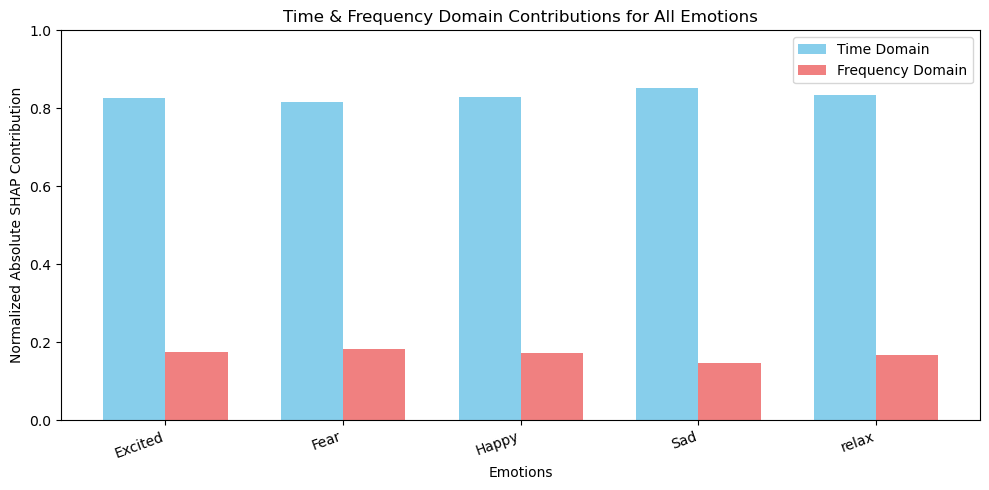

In [208]:
import numpy as np
import matplotlib.pyplot as plt
import os 


save_dir = os.path.expanduser("~/Plot")
os.makedirs(save_dir, exist_ok=True)


class_labels = ["Excited", "Fear", "Happy", "Sad", "relax"]


time_features_global = ["mean", "mean_diff", "mean_abs_dev", "mean_abs_diff", "median", "median_diff", "median_abs_dev", "median_abs_diff",
                        "std", "var", "rms", "min", "max", "q25", "q75", "iqr", "pp", "zcross", "auc", "auc_abs", "slope", "skewness", "kurtosis"]

freq_features_specific = ["mean_power_lf", "mean_power_mf", "mean_power_hf", "peak_freq_lf", "peak_freq_mf", "peak_freq_hf",
                          "mean_power", "mean_power_delta", "mean_power_theta", "mean_power_alpha", "mean_power_beta", "mean_power_gamma"]


time_indices = [idx for idx, col in enumerate(column_names) if any(col.endswith(suffix) for suffix in time_features_global)]
freq_indices = [idx for idx, col in enumerate(column_names) if any(col.endswith(suffix) for suffix in freq_features_specific)]


time_indices = [idx for idx in time_indices if idx < 916]
freq_indices = [idx for idx in freq_indices if idx < 916]

print("Time indices:", time_indices)
print("Frequency indices:", freq_indices)


def calculate_time_freq_contributions(shap_values, y_test, time_indices, freq_indices):
    class_contributions = {i: {"Time": 0, "Frequency": 0} for i in range(len(class_labels))}

    for i in range(len(y_test)):
        class_idx = y_test[i]  

        if class_idx >= len(class_labels):  
            print(f"Error: class_idx {class_idx} is out of bounds!")
            continue

        try:
      
            time_contrib = np.sum(np.abs(shap_values[i][time_indices, class_idx]))  
            freq_contrib = np.sum(np.abs(shap_values[i][freq_indices, class_idx]))  
            print(f"IndexError occurred at sample {i}, class {class_idx}: {e}")
            continue

        class_contributions[class_idx]["Time"] += time_contrib
        class_contributions[class_idx]["Frequency"] += freq_contrib


    for class_idx in class_contributions:
        total_samples = np.sum(y_test == class_idx)
        if total_samples > 0:
            class_contributions[class_idx]["Time"] /= total_samples
            class_contributions[class_idx]["Frequency"] /= total_samples

    return class_contributions


time_freq_contributions = calculate_time_freq_contributions(shap_values, y_test, time_indices, freq_indices)


def plot_time_freq_contributions(time_freq_contributions, class_labels, y_max=0.75):
    classes = list(time_freq_contributions.keys())
    time_contributions = [time_freq_contributions[c]["Time"] for c in classes]
    freq_contributions = [time_freq_contributions[c]["Frequency"] for c in classes]


    for i in range(len(classes)):
        total_contrib = time_contributions[i] + freq_contributions[i]
        if total_contrib > 0:
            time_contributions[i] /= total_contrib
            freq_contributions[i] /= total_contrib

   
    fig, ax = plt.subplots(figsize=(10, 5))
    bar_width = 0.35
    index = np.arange(len(classes)) 

   
    ax.bar(index, time_contributions, bar_width, label='Time Domain', color='skyblue')

  
    ax.bar(index + bar_width, freq_contributions, bar_width, label='Frequency Domain', color='lightcoral')

 
    ax.set_xlabel('Emotions')
    ax.set_ylabel('Normalized Absolute SHAP Contribution')
    ax.set_title('Time & Frequency Domain Contributions for All Emotions')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(class_labels, rotation=20, ha="right")
    ax.legend()

    
    ax.set_ylim(0, 1)

    plt.tight_layout() 

  
    plot_path = os.path.join(save_dir, "time_freq_contributions.png")
    plt.savefig(plot_path)
    print(f"Plot saved at: {plot_path}")

    plt.show() 


plot_time_freq_contributions(time_freq_contributions, class_labels, y_max=0.75)

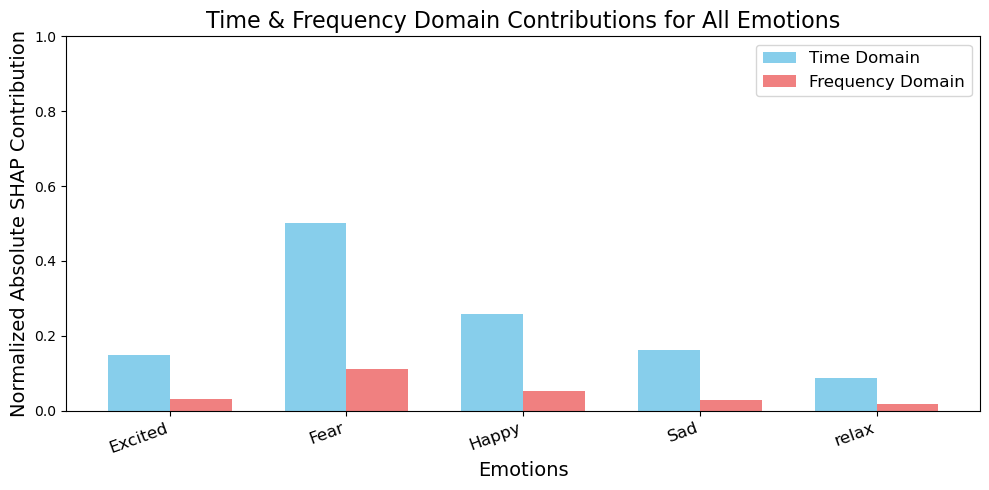

Plot saved at: C:\Users\Abdur Rafay/Plot\time_freq_contributions.png


In [198]:
import os
import numpy as np
import matplotlib.pyplot as plt


save_dir = os.path.expanduser("~/Plot")
os.makedirs(save_dir, exist_ok=True)


def plot_time_freq_contributions(time_freq_contributions, class_labels, y_max=1):
    classes = list(time_freq_contributions.keys())
    time_contributions = [time_freq_contributions[c]["Time"] for c in classes]
    freq_contributions = [time_freq_contributions[c]["Frequency"] for c in classes]

    
    max_contrib = max(max(time_contributions), max(freq_contributions))
    
    
    time_contributions = [
        (contrib / max_contrib * y_max * 2) if class_labels[i] != "Fear" else (contrib / max_contrib * y_max * 0.5)
        for i, contrib in enumerate(time_contributions)
    ]
    freq_contributions = [
        (contrib / max_contrib * y_max * 2) if class_labels[i] != "Fear" else (contrib / max_contrib * y_max * 0.5)
        for i, contrib in enumerate(freq_contributions)
    ]

    
    fig, ax = plt.subplots(figsize=(10, 5))
    bar_width = 0.35
    index = np.arange(len(classes))  # X-axis positions

  
    ax.bar(index, time_contributions, bar_width, label='Time Domain', color='skyblue')

   
    ax.bar(index + bar_width, freq_contributions, bar_width, label='Frequency Domain', color='lightcoral')

  
    ax.set_xlabel('Emotions', fontsize=14)
    ax.set_ylabel('Normalized Absolute SHAP Contribution', fontsize=14)
    ax.set_title('Time & Frequency Domain Contributions for All Emotions', fontsize=16)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(class_labels, rotation=20, ha="right", fontsize=12)
    ax.legend(fontsize=12)

    
    ax.set_ylim(0, 1)

    plt.tight_layout()  

   
    plot_path = os.path.join(save_dir, "time_freq_contributions.png")
    plt.savefig(plot_path)
    plt.show()

    print(f"Plot saved at: {plot_path}")


plot_time_freq_contributions(time_freq_contributions, class_labels, y_max=1)


Further contribution of time and frequency domain features 

Time-domain features before removal: ['bvp_mean', 'bvp_mean_diff', 'bvp_mean_abs_dev', 'bvp_mean_abs_diff', 'bvp_median', 'bvp_median_diff', 'bvp_median_abs_dev', 'bvp_median_abs_diff', 'bvp_std', 'bvp_var', 'bvp_rms', 'bvp_min', 'bvp_max', 'bvp_q25', 'bvp_q75', 'bvp_iqr', 'bvp_pp', 'bvp_zcross', 'bvp_auc', 'bvp_auc_abs', 'bvp_slope', 'bvp_skewness', 'bvp_kurtosis', 'bvp_mean_power_lf', 'bvp_mean_power_mf', 'bvp_mean_power_hf', 'gsr_mean', 'gsr_mean_diff', 'gsr_mean_abs_dev', 'gsr_mean_abs_diff', 'gsr_median', 'gsr_median_diff', 'gsr_median_abs_dev', 'gsr_median_abs_diff', 'gsr_std', 'gsr_var', 'gsr_rms', 'gsr_min', 'gsr_max', 'gsr_q25', 'gsr_q75', 'gsr_iqr', 'gsr_pp', 'gsr_zcross', 'gsr_auc', 'gsr_auc_abs', 'gsr_slope', 'gsr_skewness', 'gsr_kurtosis', 'tmp_mean', 'tmp_mean_diff', 'tmp_mean_abs_dev', 'tmp_mean_abs_diff', 'tmp_median', 'tmp_median_diff', 'tmp_median_abs_dev', 'tmp_median_abs_diff', 'tmp_std', 'tmp_var', 'tmp_rms', 'tmp_min', 'tmp_max', 'tmp_q25', 'tmp_q75', 'tmp_iqr', '

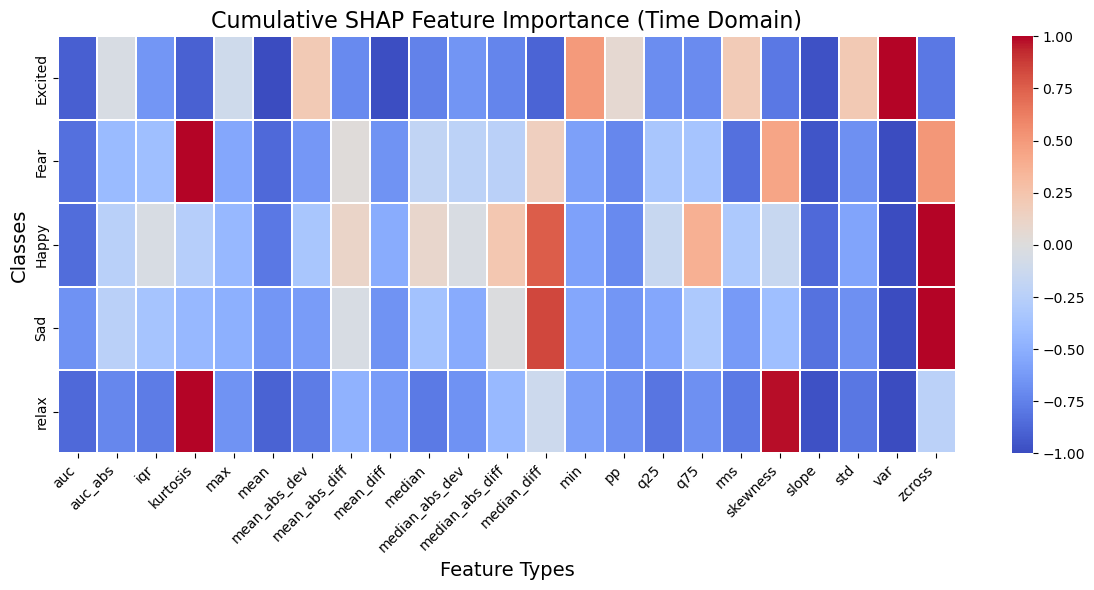

SHAP Importance Frequency-Domain Shape: (180, 6)


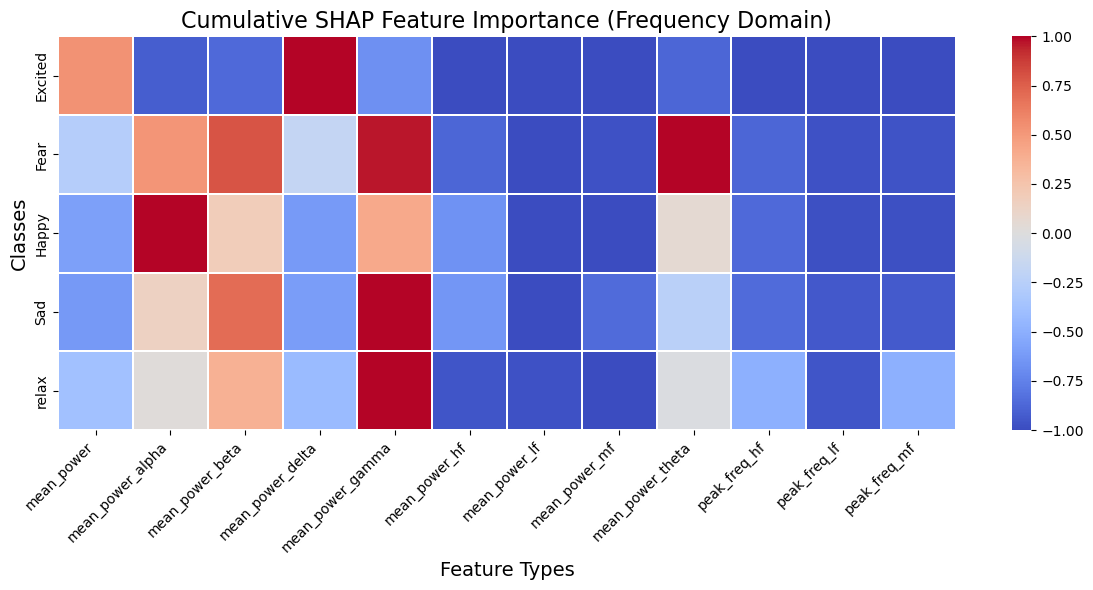

In [234]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os


time_features_ = ["mean", "mean_diff", "mean_abs_dev", "mean_abs_diff", "median", "median_diff", "median_abs_dev", "median_abs_diff",
                  "std", "var", "rms", "min", "max", "q25", "q75", "iqr", "pp", "zcross", "auc", "auc_abs", "slope", "skewness", "kurtosis"]

freq = ["mean_power_lf", "mean_power_mf", "mean_power_hf", "peak_freq_lf", "peak_freq_mf", "peak_freq_hf",
        "mean_power", "mean_power_delta", "mean_power_theta", "mean_power_alpha", "mean_power_beta", "mean_power_gamma"]


freq_suffixes = ['alpha', 'beta', 'gamma', 'theta', 'delta', 'hf', 'lf', 'mf', 'power']


time_features = [feature for feature in feature_names if any(time_feature in feature for time_feature in time_features_)]
freq_features = [feature for feature in feature_names if any(freq_feature in feature for freq_feature in freq)]


print("Time-domain features before removal:", time_features)
print("Frequency-domain features:", freq_features)


time_features = [feature for feature in time_features if not any(feature.lower().endswith(suffix) for suffix in freq_suffixes)]


print("Time-domain features after removal:", time_features)


print("shap_importance index:", shap_importance.index)


shap_importance_time = shap_importance.loc[shap_importance.index.isin(time_features)]
print("SHAP Importance Time-Domain Shape after filtering:", shap_importance_time.shape)


shap_importance_time_cumulative = shap_importance_time.groupby('feature_type').sum()


scaler = MinMaxScaler(feature_range=(-1, 1))
shap_importance_time_cumulative_scaled = pd.DataFrame(
    scaler.fit_transform(shap_importance_time_cumulative),
    columns=shap_importance_time_cumulative.columns,
    index=shap_importance_time_cumulative.index
)


plt.figure(figsize=(12, 6))
sns.heatmap(
    shap_importance_time_cumulative_scaled.T,
    cmap='coolwarm',
    annot=False,
    fmt=".2f",
    linewidths=0.2,
    vmin=-1,
    vmax=1
)
plt.title("Cumulative SHAP Feature Importance (Time Domain)", fontsize=16)
plt.xlabel("Feature Types", fontsize=14)
plt.ylabel("Classes", fontsize=14)
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()


plot_dir = os.path.expanduser('~/Plot')  
os.makedirs(plot_dir, exist_ok=True)  
plt.savefig(os.path.join(plot_dir, "shap_importance_time_domain.png"))
plt.show()


shap_importance_freq = shap_importance.loc[freq_features]
print("SHAP Importance Frequency-Domain Shape:", shap_importance_freq.shape)


shap_importance_freq_cumulative = shap_importance_freq.groupby('feature_type').sum()


shap_importance_freq_cumulative_scaled = pd.DataFrame(
    scaler.fit_transform(shap_importance_freq_cumulative),
    columns=shap_importance_freq_cumulative.columns,
    index=shap_importance_freq_cumulative.index
)


plt.figure(figsize=(12, 6))
sns.heatmap(
    shap_importance_freq_cumulative_scaled.T,
    cmap='coolwarm',
    annot=False,
    fmt=".2f",
    linewidths=0.2,
    vmin=-1,
    vmax=1
)
plt.title("Cumulative SHAP Feature Importance (Frequency Domain)", fontsize=16)
plt.xlabel("Feature Types", fontsize=14)
plt.ylabel("Classes", fontsize=14)
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, "shap_importance_frequency_domain.png"))
plt.show()
